In [27]:
import json
from IPython.display import display, Javascript, HTML, clear_output
from ipywidgets import widgets, Output, interact, fixed, Layout
from ipywidgets.widgets import Dropdown, interactive_output, VBox, HBox, interactive
from datetime import datetime, timedelta
from urllib.parse import quote_plus
from utils.notebooks import get_date_slider_from_datetime, get_next_notebook, get_previous_notebook

display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

In [3]:
%%html
<style>
summary{
    display:list-item;
}

.widget-radio-box{
    flex-direction: row;
}

.widget-radio-box input{
    margin:0 6px 0 5px
}
</style>

In [4]:
%%capture
## Some Extensions ##
%load_ext autoreload
%autoreload 2
%store -r the_page

if 'the_page' not in locals():
    import pickle
    print("Loading default data...")
    the_page = pickle.load(open("data/the_page.p",'rb'))

### <span style="color:green"> Modules Imported </span>

In [5]:
## Modules Imported ##

# Display
from IPython.display import display, Markdown as md, clear_output
from datetime import date
import urllib

# APIs
from wikiwho_wrapper import WikiWho
from external.wikipedia import WikipediaDV, WikipediaAPI
from external.wikimedia import WikiMediaDV, WikiMediaAPI
from external.xtools import XtoolsAPI, XtoolsDV

# Data Processing
import pickle
import pandas as pd
import numpy as np

# Visualization tools
import qgrid
import matplotlib.pyplot as plt

# Page views timeline
from visualization.views_listener import ViewsListener

# Change actions timeline
from visualization.actions_listener import ActionsListener

# Conflicts visualization
from visualization.conflicts_listener import ConflictsListener, ConflictsActionListener, ConflictsEditorListener
from visualization.calculator_listener import ConflictCalculatorListener

# Word cloud visualization
from visualization.wordcloud_listener import WCListener, WCActionsListener
from visualization.wordclouder import WordClouder

# Wikipedia talk pages visualization
from visualization.talks_listener import TalksListener
from visualization.topics_listener import TopicsListener

# Tokens ownership visualization
from visualization.owned_listener import OwnedListener

# Metrics management
from metrics.conflict import ConflictManager
from metrics.token import TokensManager

# For language selection
from utils.lngselection import abbreviation, lng_listener

In [6]:
# the method that listens to the click event
def on_button_clicked(b):
    global the_page, the_talk_page
    
    # use the out widget so the output is overwritten when two or more
    # searches are performed
    with out0:
        try:
            # query wikipedia
            wikipedia_dv = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
            search_result = wikipedia_dv.search_page(searchTerm.value)
            the_page = wikipedia_dv.get_page(search_result)
            the_talk_page = wikipedia_dv.get_page("Talk:"+search_result)
            %store the_page
            clear_output()
            display(md(f"The page that was found: **{the_page['title']}**"))
            display(md(f"Page id: **{the_page['page_id']}**"))

        except:
            clear_output()
            display(md(f'The page title *"{searchTerm.value}"* was not found'))

# Load the selection from NB1
with open('utils/language.json', 'r') as file:
    json_selection = json.load(file)
    lng_nb1 = json_selection['lng']
    title_nb1 = json_selection['search_term']

# Language selection.
languageSelection = Dropdown(options=['English', 'Deutsch', 'Español', 'Türkçe', 'Euskara'], value=lng_nb1, description='Language:')            

# by default display the last search
try:
    searchTerm = widgets.Text(the_page['title'], description='Page title:')
except:
    searchTerm = widgets.Text(title_nb1, description='Page title:')

second_select = widgets.interactive(lng_listener, lng=languageSelection, search_term=searchTerm)
display(second_select.children[0])
display(second_select.children[1])

# create and display the button    
button = widgets.Button(description="Search")
display(button)

# the output widget is used to remove the output after the search field
out0 = Output()
display(out0)

# set the event
button.on_click(on_button_clicked)

# trigger the event with the default value
on_button_clicked(button)

Dropdown(description='Language:', options=('English', 'Deutsch', 'Español', 'Türkçe', 'Euskara'), value='Engli…

Text(value='The Camp of the Saints', description='Page title:')

Button(description='Search', style=ButtonStyle())

Output()

If you have input another page title and still want to use these variables in the next 4 notebooks, please refresh!

In [7]:
def run_below(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Refresh All Variables", button_style='info', min_width=500)
button.on_click(run_below)
display(button)

Button(button_style='info', description='Refresh All Variables', style=ButtonStyle())

---

# A. Change actions

**The dynamics of individual changes** to each word (and each special character) in the article are extracted by the [WikiWho API](https://www.wikiwho.net/en/api/v1.0.0-beta/). 

Below, you find several metrics for such change dynamics such as unsucessful/reverted changes and conflict. 

<br>
<details>    
    <summary style="cursor: pointer;font-weight:bold">More information about WikiWho's method</summary>


The [WikiWho API](https://www.wikiwho.net/en/api/v1.0.0-beta/) tracks the changes to every token (words or special characters) on a Wikipedia page with at least 95% accuracy, for live Wikipedia articles. It distinguishes every token in the document even when the string appears several times. E.g. "and" at the beginning of an article is a different token then "and" at the end of the article. See also [this figure](https://www.wikiwho.net/#technical_details).

That means that *not only edits* (== whole revisions) are counted, which can contain changes of many different tokens, but *every single action to every single token* is recorded. 
 <br>   
   The two most basic actions that can perfomed per token are **insertions** and **deletions**. A character change in a word, e.g. "dog" -> "dogs", is modeled as deletion of "dog" and the insertion of "dogs", two separate tokens.
 <br>   
    An **insertion** is also considered a **re-insertion** if the insertion has occured before; the only insertion of a token that is not a re-insertion is the first one (original addition of the token). Similarly, a **deletion** is also considered a **re-deletion** if the deletion has occured before.

Formally, the token history can represented by a time-ordered sequence of actions 
*(a<sub>0</sub>, ..., a<sub>n</sub>)*; note that *a<sub>0+2i</sub>* is always an insertion and 
*a<sub>1+2i</sub>* is always a deletion for i ∈ ℕ.
</details> 


---

*IMPORTANT:* For articles with a long revision history, please allow for some time to load, 
before interacting with the controls too often.

## A.1 When did certain change actions happen?

In the following graph you can
* select the *date range* and *granularity* (yearly, monthly) of the timeline (X-axis), and 
* plot any of the following *change action types* in the black, red, blue and green lines. 

<br>


<details>    
    <summary style="cursor: pointer;font-weight:bold">Explanation of the change action types</summary>

   
- **adds**: number of first-time insertions / additions
- **adds_surv_48h**: number of adds that survived at least 48 hours (after 48h, the risk of being removed is negligible on avg.)
- **adds_stopword_count**:  number of insertions that were only [stop words](https://github.com/gesiscss/wikiwho_demo_new/blob/master/data/stopword_list.txt)
<br>

- **dels**: number of deletions
- **dels_surv_48h**: number of deletions that were not resinserted in the next 48 hours 
- **dels_stopword_count**: number of deletions that were only [stop words](https://github.com/gesiscss/wikiwho_demo_new/blob/master/data/stopword_list.txt)
<br>

- **reins**: number of reinsertions
- **reins_surv_48h**: number of reinsertions that survived at least 48 hours
- **reins_stopword_count**: number of reinsertions that were only [stop words](https://github.com/gesiscss/wikiwho_demo_new/blob/master/data/stopword_list.txt)
</details>
<br>


<details>    
    <summary style="cursor: pointer;font-weight:bold">Example</summary>

For instance, if you see 10 "adds" in a month, but only 4 "adds_surv_48h", 10 completely new tokens/words have been added to the article, but only 4 of them stayed in the article for more than 2 days, which usually means the other 6 are gone for good. If "dels" are performed and don't survive, that means that these deletions have been undone, i.e., the deleted tokens have been put back. I.e., these are measurements of the longevity and stability of edit actions done to the article.
</details>

In [8]:
# create and display the button
button2 = widgets.Button(description="Load Actions", layout=Layout(width='160px'))

time_select = widgets.ToggleButtons(options=['All actions', 'Conflicts'], description='Based on:',
    tooltips=['Actions overtime', 'Conflict scores overtime']
)
display(button2, time_select)

def str2int(string):
    try:
        integer = int(string)
    except:
        integer = 0

    return integer

def on_click_details(b):
    global agg_actions
    global editors
    global action_types
    global sources    
    global actions_inc_stop
    global actions_exc_stop
    global con_manager_all
    global con_manager
    global all_content
    global revisions
    global listener
    with out4:
        clear_output()
       
        # Preparetory works
        wikiwho = WikiWho(lng=abbreviation(languageSelection.value))
        display(md("Downloading all_content from the WikiWhoApi..."))
        all_content = wikiwho.dv.all_content(the_page['page_id'])
        display(md("Downloading revisions from the WikiWhoApi..."))
        revisions = wikiwho.dv.rev_ids_of_article(the_page['page_id'])
        clear_output()
        
        con_manager_all = ConflictManager(all_content.copy(), 
                                           revisions.copy(), 
                                           lng=abbreviation(languageSelection.value), 
                                           include_stopwords=True)

        con_manager = ConflictManager(all_content.copy(), 
                                       revisions.copy(), 
                                       lng=abbreviation(languageSelection.value), 
                                       include_stopwords=False)
        con_manager_all.calculate()
        con_manager.calculate()
        clear_output()
               
        token_all = con_manager_all.all_actions.copy()
        token = con_manager.all_actions.copy()
        token_elegible = con_manager.elegible_actions.copy()
        
        sources = {"tokens_all": token_all, "tokens": token, "elegibles": token_elegible}
        
        listener = ActionsListener(sources)
        init_agg_actions, actions_inc_stop, actions_exc_stop = listener.get_aggregation()
        tokens_stop = listener
        clear_output()
        
        # Visualization
        agg_actions = init_agg_actions.copy()

        # define total columns
        total_columns = ['total', 'total_surv_48h', 'total_stopword_count']

        # add columns with the total actions
        agg_actions = agg_actions.join(pd.DataFrame(
            agg_actions.loc[:,'adds':'adds_stopword_count'].values +\
            agg_actions.loc[:,'dels':'dels_stopword_count'].values +\
            agg_actions.loc[:,'reins':'reins_stopword_count'].values, 
            index=agg_actions.index, 
            columns=total_columns
        ))

        # the output widget is used to update the qgrid
        print("Downloading editor usernames (i.e. *editor* column)...")

        clear_output()
        # Grab user names from wikipedia and merge them to the editors_conflict dataframe
        wikipedia_dv = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))

        agg_actions["editor"] = agg_actions["editor"].apply(lambda x: str2int(x))
        agg_actions = agg_actions.rename({"editor": "editor_id"}, axis=1)
        editors = wikipedia_dv.get_editors(agg_actions['editor_id'].unique()).rename(columns = {
            'userid': 'editor_id'})

        # Merge the names of the editors to the aggregate actions dataframe
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
        agg_actions = agg_actions.merge(editors[['editor_id', 'name']], on='editor_id')
        agg_actions.insert(2, 'editor', agg_actions['name'])
        agg_actions = agg_actions.drop(columns=['name'])
        agg_actions['editor'] = agg_actions['editor'].fillna("Unregistered")

        # Convert to datetime
        agg_actions['rev_time'] = pd.to_datetime(agg_actions['rev_time'])

        # Group the data by year month and page (drop the editor information)
        agg_actions.drop('editor_id', axis=1).groupby(['rev_time', 'page_id']).sum().reset_index()

        # Listener
        action_types = (agg_actions.columns[4:13]).values.tolist()

        # Visualization
        datepicker_from = widgets.DatePicker(description='Date starts', value=agg_actions['rev_time'].iloc[0], layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=agg_actions['rev_time'].iloc[-1], layout=Layout(width='25%'))
        editor_all = fixed('All')
        frequency = Dropdown(options=['Yearly', 'Monthly', 'Daily'], value='Monthly', description="Granularity")
        black_actions = Dropdown(options=action_types, value='adds', description="Black")
        red_actions = Dropdown(options= ['None'] + action_types, value='dels', description="Red")
        green = Dropdown(options= ['None'] + action_types, value='None', description="Green")
        blue = Dropdown(options= ['None'] + action_types, value='None', description="Blue")
        
        metrics = ['Conflict Score', 'Total Elegible Actions', 'Absolute Conflict Score']
        black_conflicts = Dropdown(options=metrics, value='Conflict Score', description="Black")
        red_conflicts = Dropdown(options= ['None'] + metrics, value='None', description="Red")
        
        # All actions
        listener.prelisten(agg_actions)
        actions_out = interactive(listener.listen, 
            _range1 = datepicker_from,
            _range2 = datepicker_to,
            editor = fixed('All'),
            granularity = frequency,
            black = black_actions,
            red = red_actions,
            green = green,
            blue = blue)
        
        # Conflicts
        con_listener = ConflictsListener(agg_actions)        
        conflict_score = agg_actions.conflict.sum() / agg_actions.elegibles.sum()        
        
        if (conflict_score != 0):
            conflict_out = interactive(con_listener.listen,
                _range1 = datepicker_from,
                _range2 = datepicker_to,
                granularity = frequency,
                black = black_conflicts,
                red = red_conflicts)
            
        if time_select.value == 'All actions':
            display(actions_out)
        elif time_select.value == "Conflicts":
            display(md(f'**Page conflict score: {conflict_score}**'))
            display(conflict_out)

    
out4 = Output()
display(out4)

# set the event
button2.on_click(on_click_details)
time_select.observe(on_click_details, 'value')

# trigger the event with the default value
on_click_details(button2)

Button(description='Load Actions', layout=Layout(width='160px'), style=ButtonStyle())

ToggleButtons(description='Based on:', options=('All actions', 'Conflicts'), tooltips=('Actions overtime', 'Co…

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Load Actions' button: </span>

In [9]:
### --------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Load Actions' BUTTON ###
### --------------------------------------------------------------------------- ###

## Create a WikiWho instance, which is an API; and use ConflictManager to get         ##
## editons for given page id; more details see:                                       ##
## https://github.com/gesiscss/wikiwho_wrapper/blob/master/wikiwho_wrapper/api.py     ##
## https://github.com/gesiscss/wikiwho_wrapper/blob/master/wikiwho_wrapper/wikiwho.py ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/metrics/conflict.py       ##
wikiwho_api = WikiWho(lng=abbreviation(languageSelection.value))
print("Downloading all_content from the WikiWhoApi...")
all_content = wikiwho_api.dv.all_content(the_page['page_id'])
print("Downloading revisions from the WikiWhoApi...")
all_revisions = wikiwho_api.dv.rev_ids_of_article(the_page['page_id'])
clear_output()

cm_inc = ConflictManager(all_content.copy(), 
                       all_revisions.copy(), 
                       lng=abbreviation(languageSelection.value), 
                       include_stopwords=True)

cm_noinc = ConflictManager(all_content.copy(), 
                       all_revisions.copy(), 
                       lng=abbreviation(languageSelection.value), 
                       include_stopwords=False)
cm_inc.calculate()
cm_noinc.calculate()
clear_output()

tokens_inc = cm_inc.all_actions.copy()
tokens_noinc = cm_noinc.all_actions.copy()
elegibles_noinc = cm_noinc.elegible_actions.copy()
token_sources = {"tokens_all": tokens_inc, "tokens": tokens_noinc, "elegibles": elegibles_noinc}

## Create an ActionsListener instance to get aggregated actions. More details see:            ##
## https://github.com/gesiscss/wikiwho_demo_new/blob/master/visualization/actions_listener.py ##

actions_listener = ActionsListener(token_sources)
get_agg_actions, actions_inc, actions_noinc = actions_listener.get_aggregation()
clear_output()

total_actions = get_agg_actions.copy()

## Convert some columns' names to what we could understand ##
total_columns_names = ['total', 'total_surv_48h', 'total_stopword_count']

## Add all actions together and merge them into one aggregation dataframe.
total_actions = total_actions.join(pd.DataFrame(
    total_actions.loc[:,'adds':'adds_stopword_count'].values +\
    total_actions.loc[:,'dels':'dels_stopword_count'].values +\
    total_actions.loc[:,'reins':'reins_stopword_count'].values, 
    index=total_actions.index, 
    columns=total_columns_names
))

## Convert editor's ids to int64, in order to retrieve editors' names from API
total_actions["editor"] = total_actions["editor"].apply(lambda x: str2int(x))
total_actions = total_actions.rename({"editor": "editor_id"}, axis=1)

## Only editors id? No, we still want to know their names. Use WikipediaAPI to achieve ##
## this. More details see:                                                             ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/wikipedia.py          ##
wikipediadv_instance = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))

# Unique editor's id for getting their names
unique_ids = total_actions['editor_id'].unique()

# Grab editors' names

grabbed_names = wikipediadv_instance.get_editors(unique_ids).rename(columns = {'userid': 'editor_id'})

## Merge the names of editors to the total actions dataframe ##

# Merge on editors ids
total_actions = total_actions.merge(grabbed_names[['editor_id', 'name']], on='editor_id')

# Adjust the column position and fill NaN by 'Unregistered'
total_actions.insert(2, 'editor', total_actions['name'])
total_actions = total_actions.drop(columns=['name'])
total_actions['editor'] = total_actions['editor'].fillna("Unregistered")

## Continue to use our data from A.1; first convert the date to the type datetime ##
total_actions['rev_time'] = pd.to_datetime(total_actions['rev_time'])

## visualization, core visual code lies in ActionsListener, then the interact function    ##
## make it interactive, mode details see:                                                 ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/actions_listener.py ##

## This is the page you used ##
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

# Which types do those actions have?
actions_types = (total_actions.columns[4:13]).values.tolist()

# Visualization: try yourself by coding!
begin_date = date(2002, 3, 1)
end_date = date(2019, 4, 1)
editor_name = 'All'
frequency = 'Monthly' # 'Monthly', 'Yearly', 'Daily'
black_line = 'adds' # Choose one from 'actions_types'. Note that 'black_line doesn't have 'None' option but others have.
red_line = 'dels'
blue_line = 'None'
green_line = 'None'

actions_listener.prelisten(total_actions)
actions_listener.listen(
    _range1 = begin_date,
    _range2 = end_date,
    editor = editor_name,
    granularity = frequency,
    black = black_line,
    red = red_line,
    blue = blue_line,
    green = green_line
)

# Store the variable total_actions for the next notebooks.
%store total_actions

The page that is being used: The Camp of the Saints (EN)


Stored 'total_actions' (DataFrame)


## A.2 Who is responsible for these changes?

If you want to track revision history **until** that day, select a rev_time (row) in the below table and a link to Wikipedia's revision history will be provided underneath the table.

In [10]:
# create and display the button
button2 = widgets.Button(description="Get Actions", layout=Layout(width='150px'))
display(button2)

# set the default max number of rows to 10 so the larger DataFrame we render don't take up to much space 
qgrid.set_grid_option('maxVisibleRows', 12)

def on_selection_change(change):
    with out21:
        clear_output()
        
        # Extract the time selected and convert it to string.
        time_selected = qgrid_obj.get_selected_df().reset_index()['rev_time'].iloc[0]        
        date_for_search = pd.Series(time_selected).astype(str).iloc[0][0:10]
        
        # Print URL.
        url = f"https://{abbreviation(languageSelection.value)}.wikipedia.org/w/index.php?date-range-to={date_for_search}&tagfilter=&title={the_page['title'].replace(' ', '_')}&action=history"
        print(url)

def click_total_actions(b):
    global agg_actions
    global qgrid_obj
    with out2:
        clear_output()
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
        wikiwho = WikiWho(lng=abbreviation(languageSelection.value))

        # define total columns
        total_columns = ['total', 'total_surv_48h', 'total_stopword_count']
       
        # url
        url_a = wikiwho.dv.api.base_editor + f'/page/{the_page.page_id}'
        display(md(f"Actions data can be found in:"))
        print(url_a)
        
        agg_actions["rev_time"] = pd.to_datetime(agg_actions["rev_time"].dt.date)
        agg_actions = agg_actions.groupby(["rev_time", "editor", "editor_id"]).agg({key: "sum" for key in agg_actions.columns[4:]}).reset_index()
        
        qgrid_obj = qgrid.show_grid(agg_actions[['rev_time', "editor"] + action_types].set_index('rev_time').sort_index(ascending=False),
                               grid_options={'forceFitColumns':False})
        display(qgrid_obj)
        
        qgrid_obj.observe(on_selection_change, names=['_selected_rows'])
        
        out21.clear_output()

out2 = Output()
display(out2)
out21 = Output()
display(out21)

# set the event
button2.on_click(click_total_actions)

# trigger the event with the default value
click_total_actions(button2)

Button(description='Get Actions', layout=Layout(width='150px'), style=ButtonStyle())

Output()

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Get Actions' button: </span>

In [11]:
### -------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Get Actions' BUTTON ###
### -------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

## url: use the previous wikiwho_api instance##
url_actions = wikiwho_api.dv.api.base_editor + f'/page/{the_page.page_id}'
print("Actions data can be found in:", url_actions)

## Display the dataframe using interactive grid, you could learn more through the doc: ##
## https://qgrid.readthedocs.io/en/latest/                                             ##
total_actions["rev_time"] = pd.to_datetime(total_actions["rev_time"].dt.date)
total_actions = total_actions.groupby(["rev_time", "editor", "editor_id"]).agg({key: "sum" for key in total_actions.columns[4:]}).reset_index()

display(qgrid.show_grid(total_actions[['rev_time', 'editor'] + actions_types].set_index('rev_time').sort_index(ascending=False),
                       grid_options={'forceFitColumns': False}))

## Select a month by coding and you can access all the revision history until this month through a link. ##
select_month = '2018-07-01'  # Any yyyy-mm-dd value in 'rev_time' column.

# Print url.
url_revision_history = f"https://{abbreviation(languageSelection.value)}.wikipedia.org/w/index.php?date-range-to={select_month}&tagfilter=&title={the_page['title'].replace(' ', '_')}&action=history"
print('Select one row with particular month then you can track all revision history until the end of this month on Wikipedia through a link.')
print(url_revision_history)

The page that is being used: The Camp of the Saints (EN)
Actions data can be found in: https://api.wikiwho.net/en/edit_persistence/v1.0.0-beta/page/1636145


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

Select one row with particular month then you can track all revision history until the end of this month on Wikipedia through a link.
https://en.wikipedia.org/w/index.php?date-range-to=2018-07-01&tagfilter=&title=The_Camp_of_the_Saints&action=history


## A.3 Which words were changed?

The following WordCloud and table present the most 100 popular token strings that are either **added** or **undone (deleted/reinserted)**. The table also presents the detailed actions of each token.

<br>


<details>    
    <summary style="cursor: pointer;font-weight:bold">Explanation of the change action types</summary>

   
- **adds**: number of first-time insertions (additions)
- **adds_48h**: number of adds that survived at least 48 hours
- **adds_48h_ratio**: adds_48h / adds
<br>

- **dels**: number of deletions
- **dels_48h**: number of deletions that were not resinserted in the next 48 hours
- **dels_48h_ratio**: dels_48h / dels
<br>

- **reins**: number of reinsertions
- **reins_48h**: number of reinsertions that survived at least 48 hours
- **reins_48h_ratio**: reins_48h / reins
</details>

In case you are insterested in a particular token, e.g. "racist", just click the token (row) in the table and another table containing all revision history of this token within the selected date range will appear beneath the first table. Furthermore, if you want to investigate one action implemented on that token, then click that action (revision row) and a link to Wikipedia will be provided below for comparing different revisions.

### Most frequent conflicting token strings
The WordCloud displays the most common conflicting token strings, i.e. words (token strings) 
with the most actions that have conflict. The size of the token string in the WordCloud indicates frequency 
of actions.
In the controls you can select the *date range*, the type of *action* (insertion or deletion), and the 
*source*.

<details>    
    <summary style="cursor: pointer;font-weight:bold">Source description</summary>
    
-   **Only Conflicts**: use only the actions that are in conflict.
-   **Elegible Actions**: use only the actions that can potentially enter into conflict, i.e. actions 
that have occurred at least twice, e.g. the token x has been inserted twice (which necessarily implies 
it was remove once), the token x has been deleted twice (which necessarily implies it was inserted twice) 
-   **All Actions**: use all tokens regardles conflict
</details>

In [12]:
# create and display the button
button3 = widgets.Button(description="Show WordCloud")
wc_select = widgets.ToggleButtons(options=['All actions', 'Conflicts', 'Both'], description='Based on:',
    tooltips=['Most frequent words changed', 'Most frequent conflicting words', 'Both']
)
display(wc_select, button3)

def on_click_wc_action(b):
    global listener
    global _range1
    with out12:
        clear_output()
    
        listener = WCActionsListener(sources={
            "cm_inc_stop": con_manager_all,
            "cm_exc_stop": con_manager,
            "tokens_inc_stop": actions_inc_stop,
            "tokens_exc_stop": actions_exc_stop
        }, lng=abbreviation(languageSelection.value))
        
        con_listener = WCListener(sources={
                "cm_inc_stop": con_manager_all,
                "cm_exc_stop": con_manager
            }, lng=abbreviation(languageSelection.value))
 

        # visualization
        date_from = revisions['rev_time'].iloc[0]
        date_to = revisions['rev_time'].iloc[-1]
        datepicker_from = widgets.DatePicker(description='Date starts', value=date(int(date_from[:4]), int(date_from[5:7]), int(date_from[8:10])), layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=date(int(date_to[:4]), int(date_to[5:7]), int(date_to[8:10])), layout=Layout(width='25%'))
        
        _range1=datepicker_from
        _range2=datepicker_to
        action=Dropdown(options=['All', 'adds', 'adds_48h', 'dels', 'dels_48h', 'reins', 'reins_48h'], value='All', description='Action')
        stopwords = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'})
        
        # conflict tokens visualization
        source=Dropdown(options=['All Actions', 'Elegible Actions', 'Only Conflicts'], value='Only Conflicts', description='Source (*)')
        con_action=Dropdown(options=['Both', 'Just Insertions', 'Just Deletions'], value='Both', description='Action')
        editor=fixed('All')
        
        out = interactive_output(listener.listen, {'_range1': _range1, '_range2':_range2, 'action':action, 'stopwords':stopwords})
        
        con_out = interactive_output(con_listener.listen, {
                 '_range1': datepicker_from,
                 '_range2': datepicker_to,
                 'source': source,
                 'action': con_action,
                 'editor': editor,
                 'stopwords': stopwords
        })

        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
                   
        if wc_select.value == 'All actions':
            display(VBox([datepicker_from, datepicker_to, action, stopwords, out]))
        elif wc_select.value == 'Conflicts':
            display(VBox([datepicker_from, datepicker_to, con_action, source, stopwords, con_out]))
        else:
            display(VBox([datepicker_from, datepicker_to, action, stopwords, out]))
            display(VBox([con_action, source, con_out]))


        

out12 = Output()
display(out12)

# set the event
button3.on_click(on_click_wc_action)
wc_select.observe(on_click_wc_action, 'value')

# trigger the event with the default value
on_click_wc_action(button3)


ToggleButtons(description='Based on:', options=('All actions', 'Conflicts', 'Both'), tooltips=('Most frequent …

Button(description='Show WordCloud', style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show WordCloud' button: </span>

The page that is being used:, The Camp of the Saints, (EN)
Time ranges from 2005-03-01 to 2020-03-01
Only top 100 most frequent words displayed.


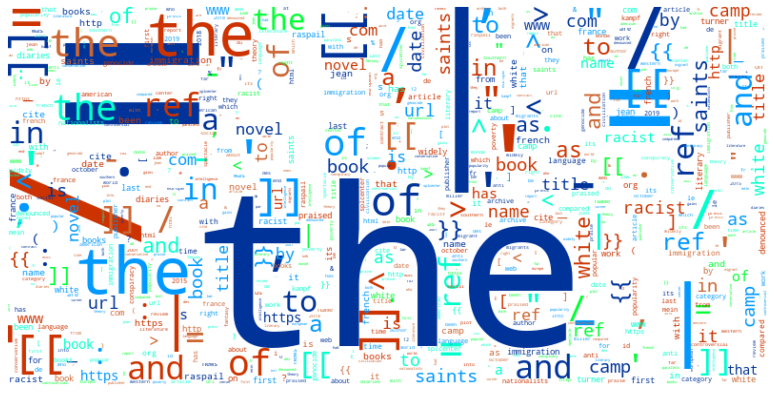

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

With token =, select one revision you want to investigate:


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

https://en.wikipedia.org/w/index.php?title=TITLEDOESNTMATTER&diff=12053908&diffmode=source


**Only top 100 most frequent conflicting words displayed.**

### The below token conflicts ocurred in a total of 189 revisions:

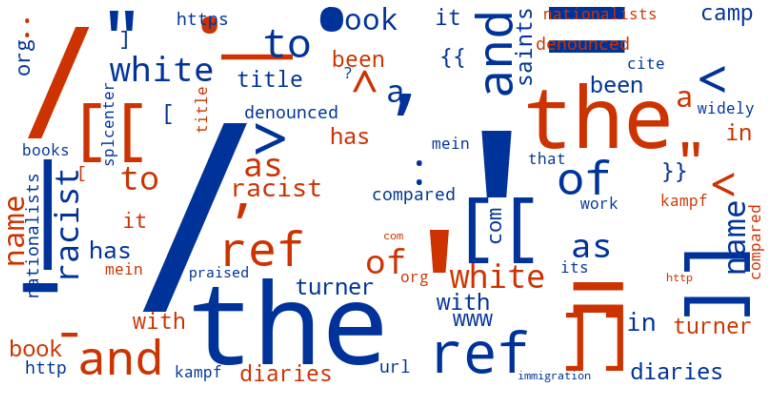

In [13]:
### ----------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show WordCloud' BUTTON ###
### ----------------------------------------------------------------------------- ###

## Visualization

# Parameters
date_start = date(2005, 3, 1)
date_end = date(2020, 3, 1)
action_type = 'All'  #'All', 'adds', 'adds_48h', 'dels', 'dels_48h', 'reins', 'reins_48h'
include_stopwords = True # 'True', False
maxwords = 100



if include_stopwords:
    token_source = cm_inc.all_actions.copy()
    adds_actions = actions_inc["adds"]
    dels_actions = actions_inc["dels"]
    reins_actions = actions_inc["reins"]
else:
    token_source = cm_noinc.all_actions.copy()
    adds_actions = actions_noinc["adds"]
    dels_actions = actions_noinc["dels"]
    reins_actions = actions_noinc["reins"]

# Use 'token_survive()' method of TokensManager to obtain the 48h survival stats for 'adds', 'dels' and 'reins' actions, details can be found in
# https://github.com/gesiscss/wikiwho_demo_new/blob/master/metrics/token.py
tokensmanager = TokensManager(token_source)

# Filter by time
filtered_actions = [adds_actions, dels_actions, reins_actions, token_source]
for loc, actions in enumerate(filtered_actions):   
    filtered_actions[loc] = actions[(actions['rev_time'].dt.date >= date_start) & (actions['rev_time'].dt.date <= date_end)]
adds_filtered, dels_filtered, reins_filtered, source_filterd = filtered_actions

# Join the tables using 'get_all_tokens()' method of TokensManager, ratio=False denotes the number of survival tokens rather than
# tokens survival rate.
tokens_stats = tokensmanager.get_all_tokens(adds_filtered, dels_filtered, reins_filtered, maxwords=maxwords, ratio=False)
tokens_stats.index = tokens_stats.index.rename("string")

# Draw WordCloud
symbol_dict = {'adds': '+', 'adds_48h': '!', 'dels': '-', 'dels_48h': '@', 'reins': '*', 'reins_48h': '#'}
if action_type == 'All':
    long_list = []
    tokens_for_wc = tokens_stats.rename(symbol_dict, axis=1)
    for col in list(tokens_for_wc.columns):
        tokens_for_wc[col].index = tokens_for_wc[col].index + f'{col}'  # Label actions
        long_list.append(tokens_for_wc[col])
    df = pd.concat(long_list)
else:
    symbol = symbol_dict[action]
    tokens_for_wc = tokens_stats.rename({action: symbol}, axis=1)
    tokens_for_wc[symbol].index = tokens_for_wc[symbol].index + symbol  # Label actions
    df = tokens_for_wc[symbol]

if len(df) == 0:
    print("There are no words to build the word cloud.")

colors = {'+': '#003399', '!': '#0099ff', '-': '#CC3300', 
      '@': '#CC6633', '*': '#00ffcc', '#':'#00ff33'}

# Create word cloud
wc = WordClouder(df, colors, 5000)

try:
    wcr = wc.get_wordcloud()
    print(f"The page that is being used:, {the_page['title']}, ({abbreviation(languageSelection.value).upper()})")
    print(f"Time ranges from {date_start} to {date_end}")
    print(f"Only top {maxwords} most frequent words displayed.")

    # Plot
    plt.figure(figsize=(14, 7))
    plt.imshow(wcr, interpolation="bilinear")
    plt.axis("off")
    plt.show()

except ValueError:
    print("Cannot create the wordcloud, there were zero actions.")
    
# Display changed tokens in the form of table. If you want use survival ratio, set ratio=True 
# in tokensmanager.get_all_tokens().
table1 = qgrid.show_grid(tokens_stats,grid_options={'forceFitColumns':False})

# Track revision history of a particular token.
token_interest = tokens_stats.index[0]  # You can use any token you are interested in
selected_token = source_filterd[source_filterd['token'] == token_interest]  
df_selected_token = selected_token.drop(['page_id', 'o_editor', 'token', 'o_rev_id', 'article_title'], axis=1)
new_cols = ['token_id', 'action', 'rev_time', 'editor', 'rev_id']
df_selected_token = df_selected_token[new_cols].rename({'editor': 'editor_id'}, axis=1)
df_selected_token['token_id'] = df_selected_token['token_id'].astype(str)
df_selected_token['rev_id'] = df_selected_token['rev_id'].astype(str)
df_selected_token.set_index('token_id', inplace=True)
table2 = qgrid.show_grid(df_selected_token)

display(table1)
print(f'With token {token_interest}, select one revision you want to investigate:')
display(table2)

# Display revision diff url redirected to Wikipedia website.
revision_id = df_selected_token['rev_id'][5]  # You can use any revision id you are interested in
url_diff = f'https://{abbreviation(languageSelection.value)}.wikipedia.org/w/index.php?title=TITLEDOESNTMATTER&diff={revision_id}&diffmode=source'
print(url_diff)
          
## MOST FREQUENT CONFLICTING TOKEN STRINGS ##
## WordCloud, core visual code lies in WCListener, then the interact function               ##
## make it interactive, mode details see:                                                   ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/wordcloud_listener.py ##
# Create a WCListener instance, continue to use our data from B.1"                          ##
wclistener = WCListener(sources={"cm_inc_stop": con_manager_all, "cm_exc_stop": con_manager}, lng=abbreviation(languageSelection.value))

# visualization: you could also perform it by coding!
editor='All'
conflict_action = 'Both' #'Just Insertions', 'Just Deletions'
conflict_source = 'Only Conflicts' #'All Actions', 'Elegible Actions'


wclistener.listen(
     _range1=date_start,
     _range2=date_end,
     source=conflict_source,
     action=conflict_action,
     editor=editor,
     stopwords=include_stopwords
)

---
# B. Conflicts

## B.1 When did conflicts happen?

Our measurement of ***conflict*** for single tokens is taken from [Flöck et al.](https://arxiv.org/abs/1703.08244):


* (1)  The main idea is to count how often a token  - after being created (added) the first time -  was being deleted, re-inserted, re-deleted, re-inserted, and so on; which would often happen in case two editors disagree on the token's justification to be in the text. 
* (2) Only the **re-**deletions and **re-**insertions are counted, since up to the first delete it could be a simple correction that didn't trigger a reponse - this wouldn't indicate conflict. 
* (3) The **"re-"** actions are only counted if they alternate between different editors and don't come from the same editor twice or more in a row - as the latter would simply indicate self-corrections. 
* (4) In a last step, each re-insertion/re-deletion interaction gets a higher weight the faster it occurs (see [Flöck et al.](https://arxiv.org/abs/1703.08244) for the exact formula).

The total conflict of a page is the sum of all the conflict scores of all actions with 
conflict (or conflict actions).

<mark> *Question: What is the exact definition of conflict scores of actions?* </mark>

This total conflict can be normalized if the sum is divided by the number of 
actions that could potentially be counted as conflict (elegible actions, i.e **"re-"** actions that have occurred at 
least twice).

The conflict scores in all notebooks are calculated based on the tokens excluding stopwords.

In the following graph you can select the *date range* and *granularity* (yearly, monthly) 
of the timeline (X-axis), and plot any of the following counts in the black and red lines:
<details>    
    <summary style="cursor: pointer;font-weight:bold">Options description</summary>
    
- **Total**: total number of actions (insertions, and deletions)
- **Total_surv_48h**: total number of actions that survived at least 48 hours
- **Total_persistent**: total number of actions that survived until, at least, the end of the month
- **Total_stopword_count**: total number of actions that were performed in stop words
- **Total Elegible Actions**: the total number of elegible actions
- **Number of Conflicts**: the total number of conflicts
- **Number of Revisions**: the total number of revisions/edits
- **Conflict Score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **Absolute Conflict Score**: the sum of conflict scores of all actions (without division)
- **Conflict Ratio**: the count of all conflicts divided by the number of elegible actions
</details>

In [14]:
# create and display the button
button2 = widgets.Button(description="Show Page Conflict", layout=Layout(width='160px'))
display(button2)

def on_click_conflict(b):
    global datepicker_from
    with out6:
        clear_output()
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
        
        # Visualization
        listener = ConflictsListener(agg_actions)

        metrics = ['Conflict Score', 'Total Elegible Actions', 'Absolute Conflict Score']
        conflict_score = agg_actions.conflict.sum() / agg_actions.elegibles.sum()
        display(md(f'**Page conflict score: {conflict_score}**'))
        
        # Visualization
        datepicker_from = widgets.DatePicker(description='Date starts', value=agg_actions['rev_time'].iloc[0], layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=agg_actions['rev_time'].iloc[-1], layout=Layout(width='25%'))
        if (conflict_score != 0):
            interact(listener.listen,
                     _range1 = datepicker_from,
                     _range2 = datepicker_to,
                     granularity=Dropdown(options=['Yearly', 'Monthly', 'Daily'], value='Monthly'),
                     black=Dropdown(options=metrics, value='Conflict Score'),
                     red=Dropdown(options= ['None'] + metrics, value='None'))
    

out6 = Output()
display(out6)

# set the event
button2.on_click(on_click_conflict)

# trigger the event with the default value
on_click_conflict(button2)

Button(description='Show Page Conflict', layout=Layout(width='160px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Page Conflict' button: </span>

In [15]:
### ----------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Page Conflict' BUTTON   ###
### ----------------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

## Continue to use our data from A.2; calculate the Conflict Score definded as above ##
conflict_sc = total_actions.conflict.sum() / total_actions.elegibles.sum()
print('Page conflict score is:', conflict_sc)

## visualization, core visual code lies in ConflictsListener, then the interact function    ##
## make it interactive, mode details see:                                                   ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/conflicts_listener.py ##

# First check whether the page conflict score is zero
if conflict_sc != 0:
    # Define a ConflictsListener instance
    conflicts_listener = ConflictsListener(total_actions)

    # Set parameters
    begin_date = total_actions['rev_time'].iloc[0]
    end_date = total_actions['rev_time'].iloc[-1]
    frequency = 'Daily' # 'Yearly', 'Monthly', 'Daily'
    
    # The metrics we need:
    # ['Total', 'Total_surv_48h', 'Total_persistent', 'Total_stopword_count',
    #  'Total Elegible Actions', 'Number of Conflicts', 'Number of Revisions',
    #  'Conflict Score', 'Absolute Conflict Score', 'Conflict Ratio', ('None')]
    # Note: only 'red_line' has 'None' option.
    black_line = 'Conflict Score'
    red_line = 'None'
    
    conflicts_listener.listen(
        _range1 = begin_date,
        _range2 = end_date,
        granularity = frequency,
        black = black_line,
        red = red_line
    )

The page that is being used: The Camp of the Saints (EN)
Page conflict score is: 0.86784183291576


---

## B.2 Editor Conflict Score

We can also calculate the conflict score for each individual editor. The table below presents the conflict score per editor per month. Same as A.2, the *rev_time* column denotes when this revision is created. If you want to know which tokens a particular editor have conflicts about in that day (row), please click that row. Then another frame containing all conflicting tokens with other relevant metrics will be provided underneath.

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

The main table:
- **editor_id**: the id of the editor that inserted the token (if starts with 0|, it means that the editor is not registered, and the ip is displayed instead
- **name**: the name of an editor that performed an action (if nan, it means that for this editor id, no name is found in Edit API)
- **conflict**: for an editor in a month, the sum of conflict scores of all actions divided by the number of elegible actions 

The tokens table:

Given editor and year-month:
- **token_id**: the id of the token that is being tracked
- **string**: the string of the token that is being tracked
- **elegibles**: the total number of elegible actions to that token 
- **conflicts**: the total number of conflicts to that token
- **conflict**: for a token, the sum of conflict scores of all actions divided by the number of elegible actions
- **revisions**: the total number of the revisions that involve this token
- **in_actions**: the total number of the revisions in which the actions are "in"s
- **out_actions**: the total number of the revisions in which the actions are "out"s
- **main_opponent**: another editor who has the most conflict with this token, in other words, the main opponent to that token (note: the conflict also likely occurs in another month)

</details>

In [16]:
# create and display the button
button_b2 = widgets.Button(description="Show Editor's Conflicts", layout=Layout(width='160px'))
display(button_b2)

def on_click_editor_conflict(b):
    with out_b2:
        clear_output()
        
        sources = {"conflict_manager": con_manager, "actions": actions_exc_stop}
        cel = ConflictsEditorListener(sources, editors)
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
        cel.listen()
        
        
out_b2 = Output()
display(out_b2)

# set the event
button_b2.on_click(on_click_editor_conflict)

# trigger the event with the default value
on_click_editor_conflict(button_b2)

Button(description="Show Editor's Conflicts", layout=Layout(width='160px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Editor's Conflicts' button: </span>

In [17]:
### -------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Editor's Conflicts' BUTTON ###
### -------------------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

## Continue to use our data from A.2; sum 'conflicts', 'elegibles' and 'conflict' (absolute) up by editors ##
conflicts_by_editors = total_actions.groupby(pd.Grouper(
                            key='editor_id')).agg({'conflicts': 'sum', 'elegibles': 'sum', 'conflict': 'sum'}).reset_index()

## Convert 'conflict' (absolute) to conflict ##
conflicts_by_editors['conflict'] = (conflicts_by_editors['conflict'] / conflicts_by_editors['elegibles'])

## If there are conflicts, then display it using qgrid ##
grabbed_names["editor_id"] = grabbed_names["editor_id"].astype(int)

if len(conflicts_by_editors) > 0:    
    conflicts_by_editors = grabbed_names[['editor_id', 'name']].merge(conflicts_by_editors.dropna(), 
                                                    right_index=True, on='editor_id').set_index('editor_id').dropna()
    conflicts_by_editors_noid = conflicts_by_editors.set_index('name')[['elegibles', 'conflicts', 'conflict']]
    qg_obj = qgrid.show_grid(conflicts_by_editors_noid)
    display(qg_obj)
else:
    display(md(f'**There is no Conflict Scores**')) 
    conflicts_by_editors = None

## Store the variable for the next notebook. ##
editors_conflicts = conflicts_by_editors.copy()

%store conflicts_by_editors

The page that is being used: The Camp of the Saints (EN)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Stored 'conflicts_by_editors' (DataFrame)


---

## B.3 Most frequent conflicting token strings

The WordCloud displays the most common conflicting token strings, i.e. words (token strings) 
with the most actions that have conflict. The size of the token string in the WordCloud indicates frequency 
of actions.
In the controls you can select the *date range*, the type of *action* (insertion or deletion), and the 
*source*.

<details>    
    <summary style="cursor: pointer;font-weight:bold">Source description</summary>
    
-   **Only Conflicts**: use only the actions that are in conflict.
-   **Elegible Actions**: use only the actions that can potentially enter into conflict, i.e. actions 
that have occurred at least twice, e.g. the token x has been inserted twice (which necessarily implies 
it was remove once), the token x has been deleted twice (which necessarily implies it was inserted twice) 
-   **All Actions**: use all tokens regardles conflict
</details>

In [18]:
# create and display the button
button2 = widgets.Button(description="Show WordCloud")
display(button2)

def on_click_wc(b): 
    with out11:  
        clear_output()
        revisions_display = revisions.copy()
        revisions_display.loc[:, 'rev_time'] = pd.to_datetime(revisions_display['rev_time'])
        #clear_output()
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
                   
        
        # listener
        sources = {}
        listener = WCListener(sources={
            "cm_inc_stop": con_manager_all,
            "cm_exc_stop": con_manager
        }, lng=abbreviation(languageSelection.value))

        # visualization
        datepicker_from = widgets.DatePicker(description='Date starts', value=revisions_display['rev_time'].iloc[0], layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=revisions_display['rev_time'].iloc[-1], layout=Layout(width='25%'))        
        
        source=Dropdown(options=['All Actions', 'Elegible Actions', 'Only Conflicts'], value='Only Conflicts', description='Source (*)')
        action=Dropdown(options=['Both', 'Just Insertions', 'Just Deletions'], value='Both', description='Action')
        editor=fixed('All')
        
        stopwords = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'})

        out = interactive_output(listener.listen, {
                 '_range1': datepicker_from,
                 '_range2': datepicker_to,
                 'source': source,
                 'action': action,
                 'editor': editor,
                 'stopwords': stopwords
        })

        display(VBox([datepicker_from, datepicker_to, action, source, stopwords, out]))

out11 = Output()
display(out11)

# set the event
button2.on_click(on_click_wc)

# trigger the event with the default value
on_click_wc(button2)

Button(description='Show WordCloud', style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show WordCloud' button: </span>

**Only top 100 most frequent conflicting words displayed.**

### The below token conflicts ocurred in a total of 42 revisions:

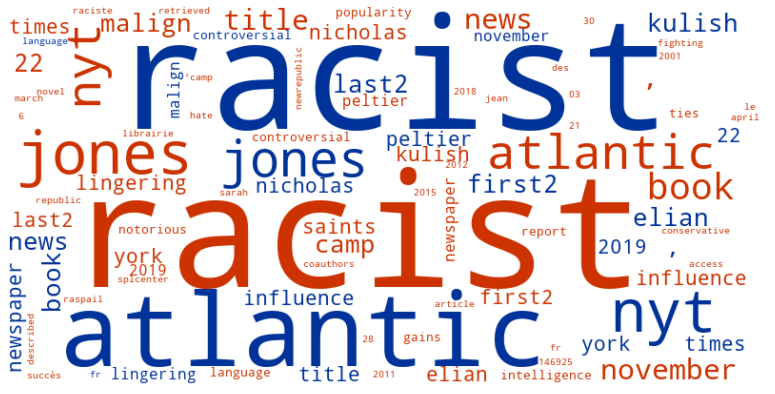

The page that is being used: The Camp of the Saints (EN)
Time range from 2020-01-01 to 2020-05-25


In [19]:
### ------------------------------------------------------------------------------ ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show WordCloud' BUTTON  ###
### ------------------------------------------------------------------------------ ###

## WordCloud, core visual code lies in WCListener, then the interact function               ##
## make it interactive, mode details see:                                                   ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/wordcloud_listener.py ##
# Create a WCListener instance, continue to use our data from B.1"                          ##
wclistener = WCListener(sources={"cm_inc_stop": con_manager_all, "cm_exc_stop": con_manager}, lng=abbreviation(languageSelection.value))

# visualization: you could also perform it by coding!
begin_date = date(2020, 1, 1)
end_date = date(2020, 5, 25)
actions_source='Only Conflicts' # 'Elegible Actions', 'All actions'
action_type='Both' # 'Just Insertions', 'Just Deletions'
editor='All'
stopwords = 'Not included'  # 'Not included', 'Included'

wclistener.listen(
     _range1=begin_date,
     _range2=end_date,
     source=actions_source,
     action=action_type,
     editor=editor,
     stopwords=stopwords
)

## This is the page you used ##,
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')
print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))

## B.4 Conflict score of each singular action

In the following table, all the actions that are in conflict are presented, and a conflict score
is presented per action. The importance of the conflict can be meassure by considering the seconds t that 
have passed since the last action on the same token (string) has occured (`time_diff_secs` column). A score to 
meassure conflict is calculated based on t with the following formula: 1 / log<sub>3600</sub>(t+2). 
Thus, *undo* actions are weighted higher than the original time in seconds when the *t* is less than an hour.
For details, please refer to [Flöck et al, 2017](https://arxiv.org/abs/1703.08244).

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

- **string**: the string of the token that is being tracked
- **order**: numerical variable, shows the order of the conflicting actions in the revision history
- **count**: numerical indicator of how often a given token is in the revision history
- **token_id**: the id of the token that is being tracked
- **rev_id**: the revision id in which the action (insertion or deletion) happen
- **editor_name**: the name of an editor that performed an action
- **editor_id**: the id of the editor that inserted the token (if starts with **0|**, it means that
the editor is not registered, and the ip is displayed instead
- **time_diff_secs**: seconds that have passed since the last action on the same token has occured
- **conflict**: a score to meassure conflict that is calculated based on the `time_diff_secs` 
with the following formula: *1 / log<sub>3600</sub>(time_diff_secs + 2)*. For details, please refer to 
[Flöck et al, 2017](https://arxiv.org/abs/1703.08244)

<mark> *Question: Should explain -1 in the rev_id column?* </mark>
</details>

In [20]:
# create and display the button
button2 = widgets.Button(description="Show Conflict Score of Each Action", layout=Layout(width='250px'))
display(button2)

def on_click_actions(b):
    global conflictaction_listener
    with out9:
        clear_output()

        revisions_for_display = revisions.copy()
        revisions_for_display.loc[:, 'rev_time'] = pd.to_datetime(revisions_for_display['rev_time'])
        
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))
        datepicker_from = widgets.DatePicker(description='Date starts', value=revisions_for_display['rev_time'].iloc[0], layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=revisions_for_display['rev_time'].iloc[-1], layout=Layout(width='25%'))
        
        conflictaction_listener = ConflictsActionListener(sources={
            "con_manager_all": con_manager_all,
            "con_manager": con_manager,
            "Editors": editors.copy(),
            "Revisions": revisions_for_display
        },lng=abbreviation(languageSelection.value), the_page = the_page)
        
        stopwords = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'})
        interact(conflictaction_listener.listen, stopwords = stopwords, _range1 = datepicker_from, _range2 = datepicker_to)

        
                
out9 = Output()
display(out9)

# set the event
button2.on_click(on_click_actions)

# trigger the event with the default value
on_click_actions(button2)

Button(description='Show Conflict Score of Each Action', layout=Layout(width='250px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Conflict Score of Each Action' button: </span>

In [21]:
### --------------------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Conflict Score of Each Action' BUTTON   ###
### --------------------------------------------------------------------------------------------------- ###

include_stopwords = False  # "True", "False"
if include_stopwords:   
    conflict_calculator = cm_inc
else:
    conflict_calculator = cm_noinc


#merging together 2 dataframes on editor_id
conf_actions = conflict_calculator.conflicts.copy()
editor_names = grabbed_names.copy()

conf_actions = conf_actions.rename(columns={"editor":'editor_id'})
editor_names['editor_id'] = editor_names['editor_id'].astype(str)
conf_actions['editor_id'] = conf_actions['editor_id'].astype(str)
conflicts_merged = editor_names[['editor_id', 'name']].merge(conf_actions, right_index=True, on='editor_id', how='outer')

## This is the page you used ##
print('The page that is being used:', the_page['title'], f'({abbreviation(languageSelection.value).upper()})')

## Display the tokens, the difference in seconds and its corresponding conflict score                 ##
## Pandas.Series.dt: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html ##
token_conflicts = conflicts_merged[conflicts_merged['token'].notnull()].copy()
token_conflicts['time_diff_secs'] = token_conflicts['time_diff'].dt.total_seconds()

## Display using qgrid ##
if len(token_conflicts) > 0:
    tokens_grid_show = token_conflicts[[
        'action', 'token', 'token_id', 'rev_id', 
        'editor_id', 'name', 'time_diff_secs', 'conflict']].rename(columns={
        'name': 'editor_name'}).sort_values('conflict', ascending=False)
    tokens_grid_show['token_id'] = tokens_grid_show['token_id'].astype(str)
    tokens_grid_show['rev_id'] = tokens_grid_show['rev_id'].astype(str)
    tokens_grid_show.set_index('token_id', inplace=True)
    display(qgrid.show_grid(tokens_grid_show))
else:
    display(md(f'**There are no conflicting tokens in this page.**'))
    display(HTML(f'<a href="{get_previous_notebook()}" target="_blank">Go back to the previous workbook</a>'))
    
# Store the variable for the next notebook.
%store conflict_calculator

The page that is being used: The Camp of the Saints (EN)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Stored 'conflict_calculator' (ConflictManager)


---
# C. Talk

## C.1 How are revisions in talk section spread over time?

The Talk page activity represents the number of revisions on the Talk page of the Wikipedia article extracted by WikiWho API. 

In the controls you can select the *date range* and the *granularity*

In [22]:
button_t = widgets.Button(description="Load Talks", layout=Layout(width='160px'))
display(button_t)

def on_click_details(b):
    global talk_content 
    with out_t:
        clear_output()
        display(md(f"***Page: {the_page['title']} ({abbreviation(languageSelection.value).upper()})***"))

        #Initiate a Wikipedia instance
        wikipediadv_instance = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
        
        #Get content of revisions on talk page
        talk_content = wikipediadv_instance.get_talk_content(the_talk_page["page_id"])
        
        #convert to datetime format
        talk_content['year_month'] = pd.to_datetime(talk_content['timestamp'])

        
        # Define a TalksListener instance
        talks_listener = TalksListener(talk_content)

        # Visualization
        datepicker_from = widgets.DatePicker(description='Date starts', value=talk_content['year_month'].iloc[-1], layout=Layout(width='25%'))
        datepicker_to = widgets.DatePicker(description='Date ends', value=talk_content['year_month'].iloc[0], layout=Layout(width='25%'))

        interact(talks_listener.listen,
            begin = datepicker_from,
            end = datepicker_to,
            granularity = Dropdown(options=['Monthly', 'Yearly', 'Daily'], value='Monthly')
        )

out_t = Output()
display(out_t)

# set the event
button_t.on_click(on_click_details)

# trigger the event with the default value
on_click_details(button_t)

Button(description='Load Talks', layout=Layout(width='160px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Load Talks' button: </span>

In [23]:
### -------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Load Talks' BUTTON  ###
### -------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_talk_page['title'])

#Initiate a Wikipedia instance
wikipediadv_instance = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))

#Get content of revisions on talk page
talk_content = wikipediadv_instance.get_talk_content(the_talk_page["page_id"])

#convert to datetime format
talk_content['year_month'] = pd.to_datetime(talk_content['timestamp'])


# Define a TalksListener instance
talks_listener = TalksListener(talk_content)

# Visualization
begin_date = date(2005, 3, 1)
end_date = date(2015, 7, 4)
granularity = 'Monthly'

print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
talks_listener.listen(
    begin = begin_date,
    end = end_date,
    granularity = granularity)

The page that is being used: Talk:The Camp of the Saints
Time range from 2005-03-01 to 2015-07-04


## C.2 What are the most revisions about?

It is also possible to review what are the talks about by subsections, under which revisions happened. The table below shows the topic of each revision, sorted by date. Although most of the times users change the content of the talk page, sometimes revisions include actions like signing a comment, deleting or reversing revisions. These actions are not presented in the table.

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

- **topic**: the string topic extracted from revision content
- **revid**: the revision id in which the action happened
- **user**: the id or ip address of the editor that inserted the token
- **year_month**: timestamp when the revision took place
- **action_type**: type of the action made in a revision (new topic added or topic edited)

</details>

The graph illustrates revisions by topics spread over time.

In the controls for the graph you can select the *date range* and the *granularity*

In [24]:
button_to = widgets.Button(description="Load Topics", layout=Layout(width='160px'))
display(button_to)

def on_click_topics(b):
    global topics_listener, topic_df
    with out_to:
        clear_output()
        display(md(f"***Page: {the_talk_page['title']} ({abbreviation(languageSelection.value).upper()})***"))

        topics_listener = TopicsListener(talk_content)

        #get a dataframe with topics and action_types
        wikipediadv_ins = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
        topic_df = topics_listener.extract_topics(wikipediadv_ins)
        
                   
        #adding transcluded content
        tr_row = talk_content[talk_content['comment'].str.match(r'Transcluding GA review')==True]
        if len(tr_row)>0:
            wikipedia_dv = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
            transcluded_page = wikipedia_dv.get_page(the_talk_page['title'] +'/GA1')
            transcluded_talk_content = wikipedia_dv.get_talk_content(transcluded_page["page_id"])
            transcluded_talk_content['year_month'] = pd.to_datetime(transcluded_talk_content['timestamp'])
            tr_topics_listener = TopicsListener(transcluded_talk_content)
            transcluded_topic_df = tr_topics_listener.translusion(wikipedia_dv).set_index('topics')
            topics_listener.topic_df = topic_df.append(transcluded_topic_df).sort_values(by='year_month', ascending = False)
        if len(topic_df) == 0:
            display(md("There is no topics here!"))
        else:        
            display(qgrid.show_grid(topics_listener.topic_df))

            # Visualization
            datepicker_from = widgets.DatePicker(description='Date starts', value=talk_content['year_month'].iloc[-1], layout=Layout(width='25%'))
            datepicker_to = widgets.DatePicker(description='Date ends', value=talk_content['year_month'].iloc[0], layout=Layout(width='25%'))

            interact(topics_listener.listen,
                begin = datepicker_from,
                end = datepicker_to,
                granularity = Dropdown(options=['Monthly', 'Yearly', 'Daily'], value='Monthly')
            )

out_to = Output()
display(out_to)

# set the event
button_to.on_click(on_click_topics)

# trigger the event with the default value
on_click_topics(button_to)

Button(description='Load Topics', layout=Layout(width='160px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Load Topics' button: </span>

In [25]:
### --------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Topics' BUTTON  ###
### --------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_talk_page['title'])
print(f"Time range from {talk_content['year_month'].iloc[-1].date()} to {talk_content['year_month'].iloc[0].date()}")

#initiate a topics listener
topics_listener = TopicsListener(talk_content)

#get a dataframe with topics and action_types
wikipediadv_ins = WikipediaDV(WikipediaAPI(lng=abbreviation(languageSelection.value)))
topic_df = topics_listener.extract_topics(wikipediadv_ins)
if len(topic_df) == 0:
    print("There is no topics here!")
else:
    display(qgrid.show_grid(topic_df))

    # Visualization
    begin_date = talk_content['year_month'].iloc[-1]  # date(xxxx.xx.xx)
    end_date = talk_content['year_month'].iloc[0]  # date(xxxx.xx.xx)
    granularity = 'Monthly'

    topics_listener.listen(
        begin = begin_date,
        end = end_date,
        granularity = granularity)

The page that is being used: Talk:The Camp of the Saints
Time range from 2007-01-11 to 2020-05-29


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [28]:
lng_selected = abbreviation(languageSelection.value)
calculator = con_manager
%store agg_actions
%store calculator
%store editors_conflicts
%store lng_selected

clear_output()
if len(editors_conflicts) > 0:
    display(HTML(f'<a href="{get_next_notebook()}" target="_blank">Go to next workbook</a>'))
else:
    display(HTML(f'<a href="{get_previous_notebook()}" target="_blank">Go back to the previous workbook</a>'))

scroll_to_top = """
<script>
document.getElementById('notebook').scrollIntoView();
</script>
"""

display(HTML(scroll_to_top))

header_len = """
document.getElementsByClassName("ui-state-default slick-header-column slick-header-sortable")[1].setAttribute("style", "width: 141px");
document.getElementsByClassName("ui-state-default slick-header-column slick-header-sortable")[2].setAttribute("style", "width: 141px");
document.getElementsByClassName("ui-state-default slick-header-column slick-header-sortable")[4].setAttribute("style", "width: 158px");
document.getElementsByClassName("ui-state-default slick-header-column slick-header-sortable")[5].setAttribute("style", "width: 141px");
document.getElementsByClassName("ui-state-default slick-header-column slick-header-sortable")[6].setAttribute("style", "width: 141px");
document.getElementsByClassName("ui-state-default slick-header-column slick-header-sortable")[7].setAttribute("style", "width: 155px");
document.getElementsByClassName("ui-state-default slick-header-column slick-header-sortable")[8].setAttribute("style", "width: 141px");
document.getElementsByClassName("ui-state-default slick-header-column slick-header-sortable")[10].setAttribute("style", "width: 171px");
"""

display(Javascript(header_len))

<IPython.core.display.Javascript object>